## iZettle Data Science Assignment - CPV ##

Thanks for taking time to complete the iZettle data science assignment.
<br>
This is to give you an idea about the challenges that we may face at iZettle. Also, it will help us understand how you would tackle them.
<br>
Feel free to scope the assignment as appropriate. Make sure to motivate what you did and why.

The goal is to estimate the Card Payment Volume (CPV) of each organization
during their first, second and third month after creation (i.e. the sum of the
amount of every transaction in each month). The prediction should be based
on the first 14 days of data after the organization was created.

You’ll find two CSV files attached with the following data:

data/organization_ids.csv:
- organization_id Unique identifier for each organization
- organization_created Date on which organization was onboarded

data/payment_ids.csv:
- organization_id Unique identifier for each organization
- card_payment_id Unique identifier for a payment that was completed
- timestamp Time of event
- currency_id Currency
- amount Amount of the transaction
- device_type The device connected to the card reader
- card_payment_entry_mode Payment technology
- payment_type Valid payment or invalid

### Imports ###

In [1]:
import pandas as pd
import numpy as np

### Data Loading and Preparation ###

We'll load the 2 csv's, and merge them on the organization id.

In [2]:
payment_df = pd.read_csv('payment_ids.csv')

In [3]:
organization_df = pd.read_csv('organization_ids.csv')

In [4]:
master_df = pd.merge(payment_df, organization_df, on='organization_id')

<br>
<br>
Let's take a quick look at the categorical columns, and see how they're distributed.

In [5]:
master_df.columns

Index(['organization_id', 'timestamp', 'amount', 'currency_id',
       'card_payment_entry_mode', 'device_type', 'payment_type',
       'organization_created'],
      dtype='object')

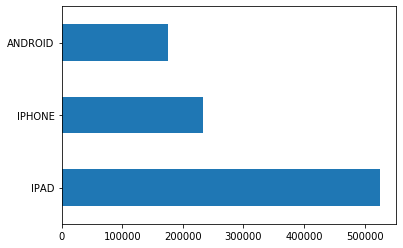

In [6]:
master_df['device_type'].value_counts().plot(kind='barh')

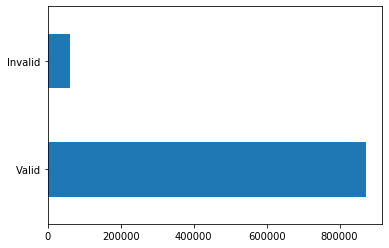

In [7]:
master_df['payment_type'].value_counts().plot(kind='barh')

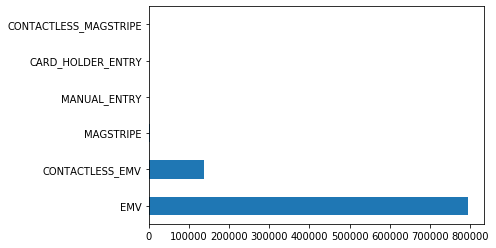

In [8]:
master_df['card_payment_entry_mode'].value_counts().plot(kind='barh')

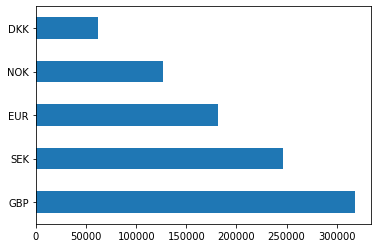

In [9]:
master_df['currency_id'].value_counts().plot(kind='barh')

<br>
<br>
Now we need to convert the time columns to timestamps, as they are originally loaded as strings.

In [10]:
master_df['timestamp'] = pd.to_datetime(master_df['timestamp'], infer_datetime_format=True, errors='coerce')
master_df['organization_created'] = pd.to_datetime(master_df['organization_created'], infer_datetime_format=True, errors='coerce')

## Feature Engineering ##

We're going to need organizational age, so we calculate that in days.

In [11]:
master_df['organization_age'] = (master_df['timestamp'] - master_df['organization_created']).dt.days

<br>
<br>
The column with the payment amount contains values in multiple currencies. In order to make meaningful predictions, we need to make the amounts uniform. We're going to convert all the amounts to Euros. First, we create variables for the different exchange rates. Then we create a list for EUR amounts which will be used for conversion. Then we convert the currencies, and add the column to the dataframe.

In [12]:
GBP = 1.14
NOK = 0.1
SEK = 0.1
DKK = 0.13

In [13]:
amount_eur = []

In [14]:
for index, row in master_df.iterrows():
    if master_df['currency_id'][index] == 'GBP':
        amount_eur.append(master_df['amount'][index] * GBP)
    elif master_df['currency_id'][index] == 'NOK':
        amount_eur.append(master_df['amount'][index] * NOK)
    elif master_df['currency_id'][index] == 'SEK':
        amount_eur.append(master_df['amount'][index] * SEK)
    elif master_df['currency_id'][index] == 'DKK':
        amount_eur.append(master_df['amount'][index] * DKK)
    else:
        amount_eur.append(master_df['amount'][index])

In [15]:
master_df['amount_eur'] = amount_eur

<br>
<br>
As we're predicting sums, we'll create features based on these sums. We have to be careful here about potential data leakage here. We'll create a feature based on the sum in the first 14 days, a feature for the rest of the first month, a feature for the seond month, and a feature for the third month.

In [25]:
amt_to_14_days_sum = master_df[master_df['organization_age'] <= 14]['amount_eur'].sum()

amt_to_14_days = []

for index, row in master_df.iterrows():
    if master_df['organization_age'][index] <= 14:
        amt_to_14_days.append(amt_to_14_days_sum)
    else:
        amt_to_14_days.append(0)
        
master_df['amt_to_14_days_sum'] = amt_to_14_days

<br>
<br>

In [28]:
amt_15_to_30_days_sum = master_df.loc[(master_df['organization_age'] >= 15) & (master_df['organization_age'] <= 30)]['amount_eur'].sum()

df_amt_15_to_30_days = ((master_df['organization_age'] >= 15) & (master_df['organization_age'] <= 30))

amt_15_to_30_days = []

for index, row in master_df.iterrows():
    if df_amt_15_to_30_days.iloc[index] :
        amt_15_to_30_days.append(amt_15_to_30_days_sum)
    else:
        amt_15_to_30_days.append(0)
        
master_df['amt_15_to_30_days_sum'] = amt_15_to_30_days

<br>
<br>


In [ ]:
amt_31_to_60_days_sum = master_df.loc[(master_df['organization_age'] >= 31) & (master_df['organization_age'] <= 60)]['amount_eur'].sum()

df_amt_31_to_60_days = ((master_df['organization_age'] >= 31) & (master_df['organization_age'] <= 60))

amt_31_to_60_days = []

for index, row in master_df.iterrows():
    if df_amt_31_to_60_days.iloc[index] :
        amt_31_to_60_days.append(amt_31_to_60_days_sum)
    else:
        amt_31_to_60_days.append(0)
        
master_df['amt_31_to_60_days_sum'] = amt_31_to_60_days

<br>
<br>

In [ ]:
amt_61_to_90_days_sum = master_df.loc[(master_df['organization_age'] >= 61) & (master_df['organization_age'] <= 90)]['amount_eur'].sum()

df_amt_61_to_90_days = ((master_df['organization_age'] >= 61) & (master_df['organization_age'] <= 90))

amt_61_to_90_days = []

for index, row in master_df.iterrows():
    if df_amt_61_to_90_days.iloc[index] :
        amt_61_to_90_days.append(amt_61_to_90_days_sum)
    else:
        amt_61_to_90_days.append(0)
        
master_df['amt_61_to_90_days_sum'] = amt_61_to_90_days